# Superstore Gold Membership Campaign Analysis
This notebook contains data cleaning, exploratory data analysis, and visualization steps for identifying factors influencing customer response to a Gold Membership offer.

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Load the dataset
df = pd.read_csv("superstore_data.csv")
df.head()

,Id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain
0,1826,1970,Graduation,Divorced,84835.0,0,0,6/16/2014,0,189,...,111,189,218,1,4,4,6,1,1,0
1,1,1961,Graduation,Single,57091.0,0,0,6/15/2014,0,464,...,7,0,37,1,7,3,7,5,1,0
2,10476,1958,Graduation,Married,67267.0,0,1,5/13/2014,0,134,...,15,2,30,1,3,2,5,2,0,0
3,1386,1967,Graduation,Together,32474.0,1,1,11/5/2014,0,10,...,0,0,0,1,1,0,2,7,0,0
4,5371,1989,Graduation,Single,21474.0,1,0,8/4/2014,0,6,...,11,0,34,2,3,1,2,7,1,0


In [ ]:
# Convert the customer join date to datetime format
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])

In [ ]:
# Fill missing income values with the median income
df['Income'] = df['Income'].fillna(df['Income'].median())

In [ ]:
# One-hot encode categorical variables 'Education' and 'Marital_Status'
df = pd.get_dummies(df, columns=['Education', 'Marital_Status'], drop_first=True)

In [ ]:
# Create a simpler 'MaritalStatus' column for visualization
df["MaritalStatus"] = df[[
    "Marital_Status_Divorced", "Marital_Status_Married", "Marital_Status_Single",
    "Marital_Status_Together", "Marital_Status_Widow", "Marital_Status_YOLO",
    "Marital_Status_Alone"
]].idxmax(axis=1).str.replace("Marital_Status_", "")

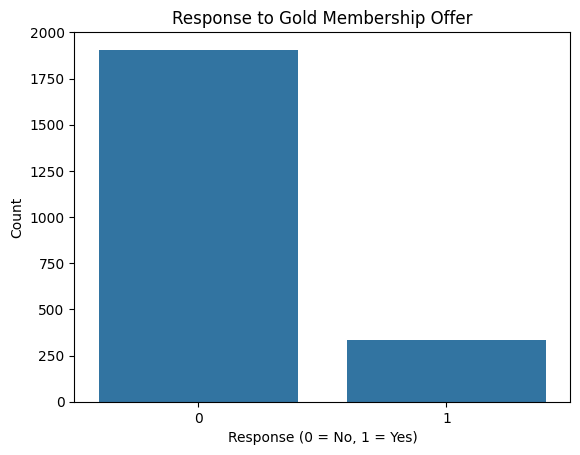

In [ ]:
# Plot distribution of response (0 = No, 1 = Yes)
sns.countplot(x="Response", data=df)
plt.title("Response to Gold Membership Offer")
plt.xlabel("Response (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

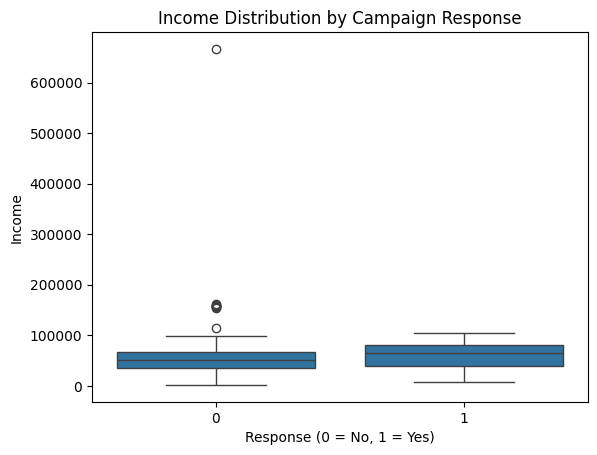

In [ ]:
# Plot income distribution by campaign response
sns.boxplot(x="Response", y="Income", data=df)
plt.title("Income Distribution by Campaign Response")
plt.xlabel("Response (0 = No, 1 = Yes)")
plt.ylabel("Income")
plt.show()

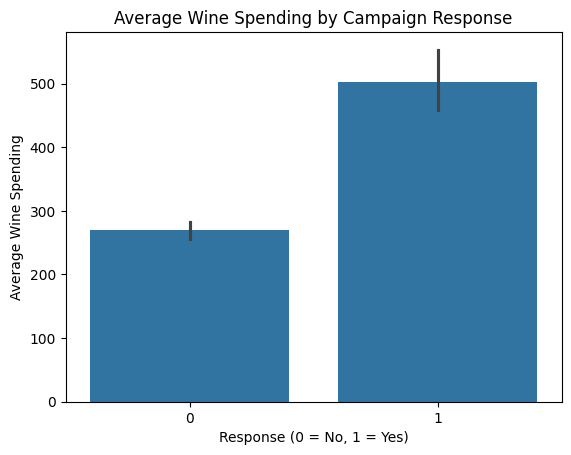

In [ ]:
# Plot average wine spending by response
sns.barplot(x="Response", y="MntWines", data=df)
plt.title("Average Wine Spending by Campaign Response")
plt.xlabel("Response (0 = No, 1 = Yes)")
plt.ylabel("Average Wine Spending")
plt.show()

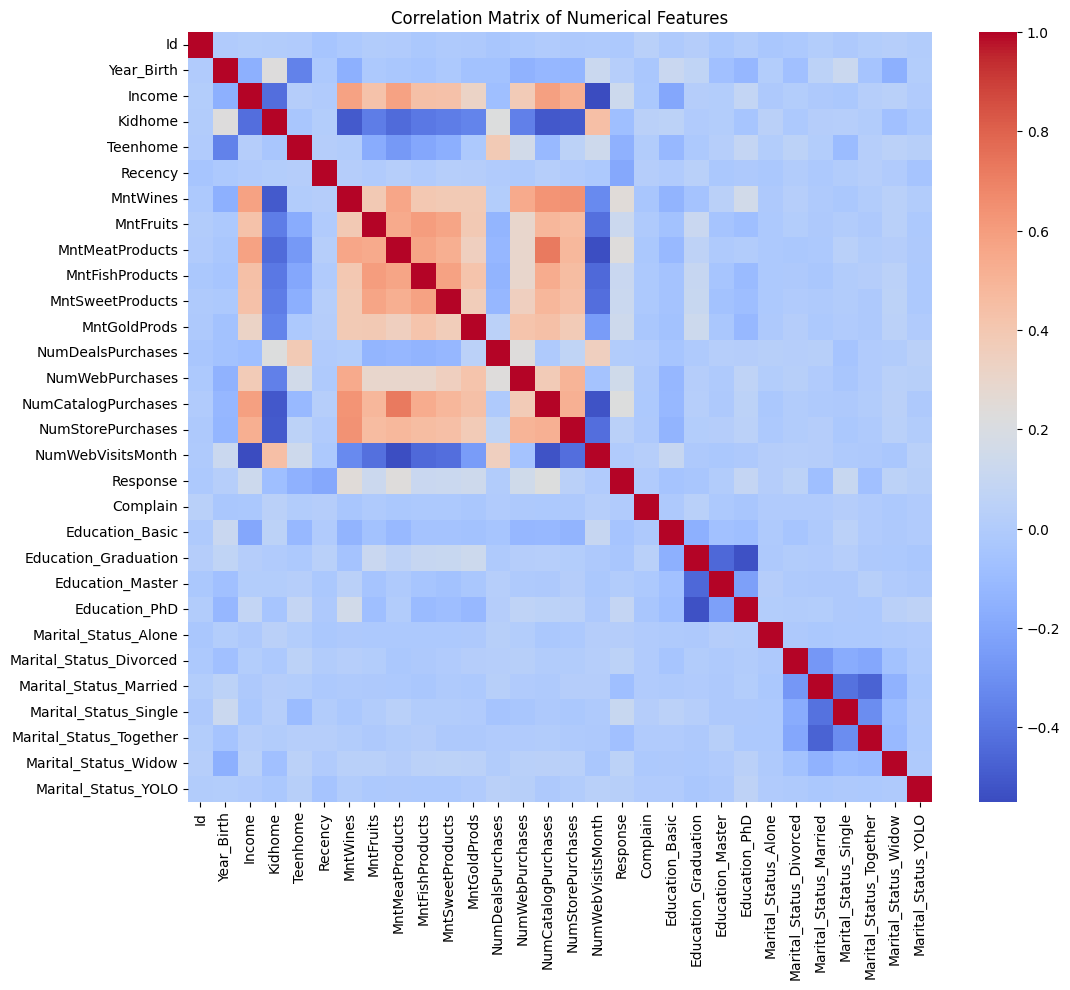

In [ ]:
# Plot correlation heatmap of all numerical features
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(numeric_only=True), cmap="coolwarm", annot=False)
plt.title("Correlation Matrix of Numerical Features")
plt.show()

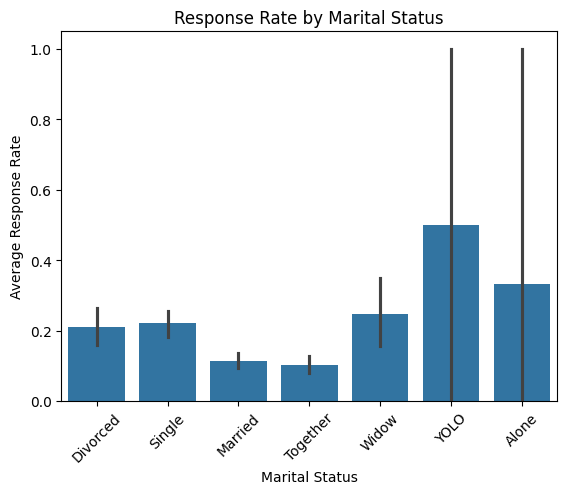

In [ ]:
# Plot average response rate by marital status
sns.barplot(x="MaritalStatus", y="Response", data=df)
plt.title("Response Rate by Marital Status")
plt.xlabel("Marital Status")
plt.ylabel("Average Response Rate")
plt.xticks(rotation=45)
plt.show()

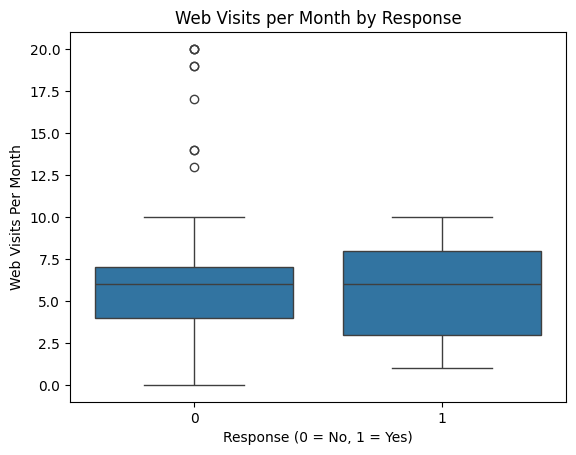

In [ ]:
# Plot web visits per month by campaign response
sns.boxplot(x="Response", y="NumWebVisitsMonth", data=df)
plt.title("Web Visits per Month by Response")
plt.xlabel("Response (0 = No, 1 = Yes)")
plt.ylabel("Web Visits Per Month")
plt.show()

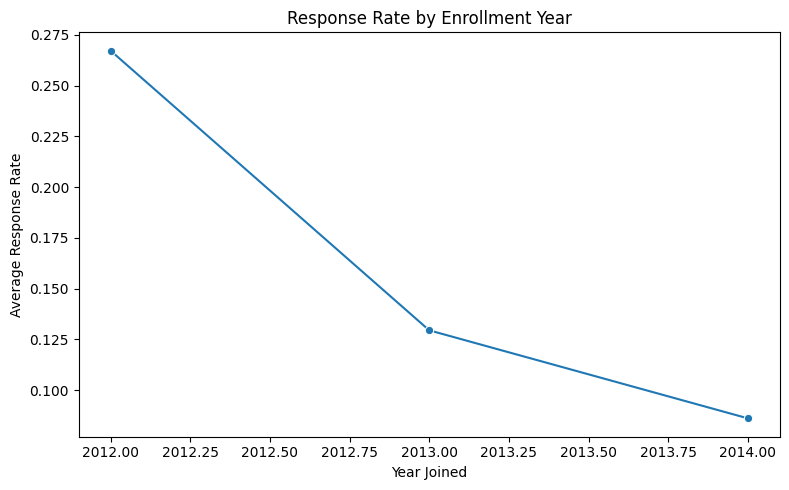

In [ ]:
# Extract enrollment year from customer join date
df['Year_Customer_Joined'] = df['Dt_Customer'].dt.year

# Calculate average response rate by year of joining
response_by_year = df.groupby('Year_Customer_Joined')['Response'].mean().reset_index()

# Plot response rate over enrollment years
plt.figure(figsize=(8, 5))
sns.lineplot(x='Year_Customer_Joined', y='Response', data=response_by_year, marker="o")
plt.title('Response Rate by Enrollment Year')
plt.xlabel('Year Joined')
plt.ylabel('Average Response Rate')
plt.tight_layout()
plt.show()

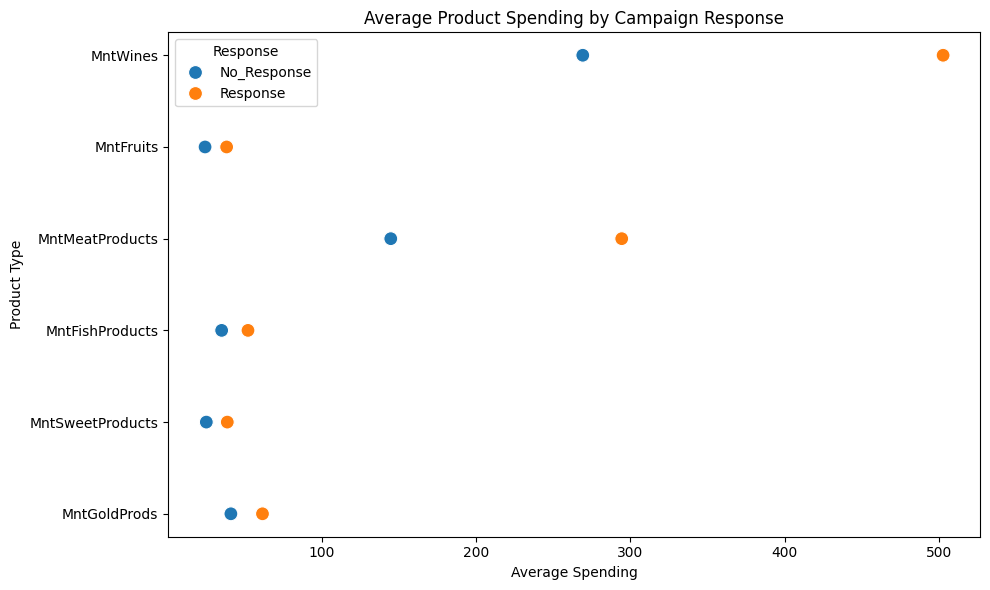

In [ ]:
# Define product spending columns for comparison
spend_cols = ['MntWines', 'MntFruits', 'MntMeatProducts',
              'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']

# Calculate average spending for responders vs non-responders
spending_means = df.groupby('Response')[spend_cols].mean().T
spending_means.columns = ['No_Response', 'Response']
spending_means = spending_means.reset_index().rename(columns={'index': 'Product'})

# Reshape data for plotting with seaborn
spending_melted = spending_means.melt(id_vars='Product',
                                      value_vars=['No_Response', 'Response'],
                                      var_name='Response Type',
                                      value_name='Average Spending')

# Plot average spending by product type and response
plt.figure(figsize=(10, 6))
sns.scatterplot(data=spending_melted, x='Average Spending', y='Product', hue='Response Type', s=100)
plt.title('Average Product Spending by Campaign Response')
plt.xlabel('Average Spending')
plt.ylabel('Product Type')
plt.legend(title='Response')
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:44:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


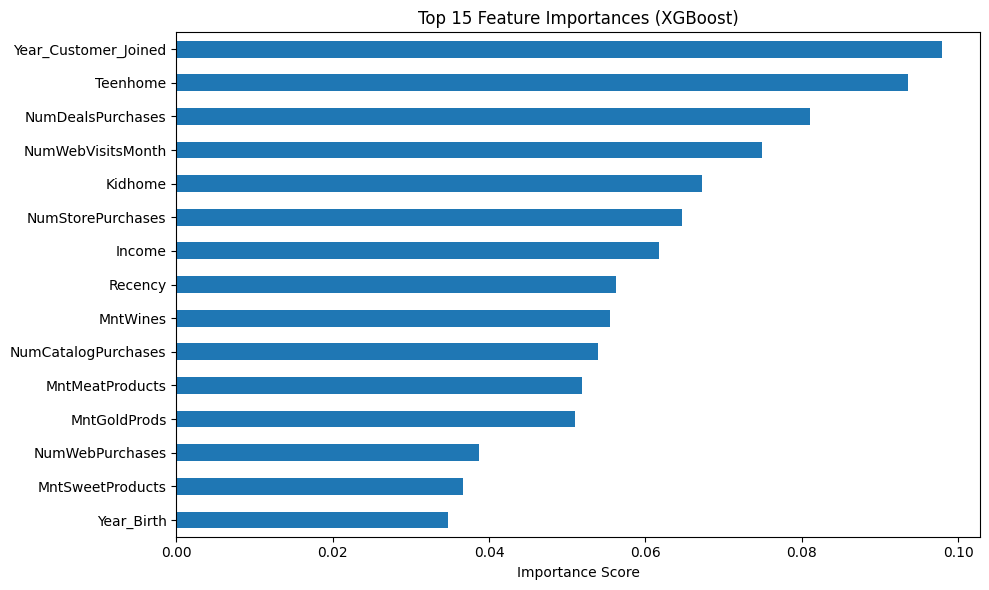

In [ ]:
# Define X and y
y = df["Response"]
X = df.select_dtypes(include=np.number).drop("Response", axis=1)

# 1. Import XGBoost
import xgboost as xgb

# 2. Split into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)


# 3. Train the XGBoost model
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

# 4. Plot feature importances
import pandas as pd
import matplotlib.pyplot as plt

importances = pd.Series(model.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False).head(15)

plt.figure(figsize=(10, 6))
top_features.plot(kind='barh')
plt.title("Top 15 Feature Importances (XGBoost)")
plt.xlabel("Importance Score")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.94      0.93       572
           1       0.60      0.48      0.53       100

    accuracy                           0.88       672
   macro avg       0.76      0.71      0.73       672
weighted avg       0.87      0.88      0.87       672

ROC AUC Score: 0.8771


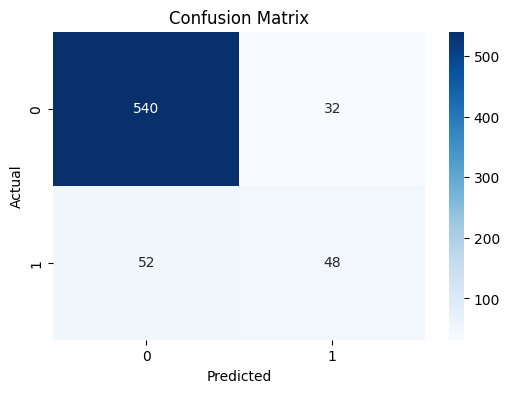

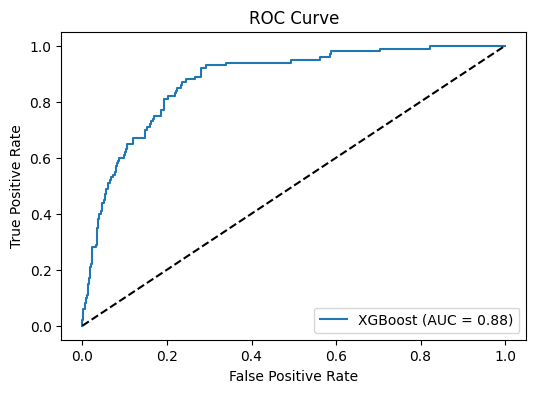

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns

# Predict on test data
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# ROC AUC score
roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC AUC Score: {roc_auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"XGBoost (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


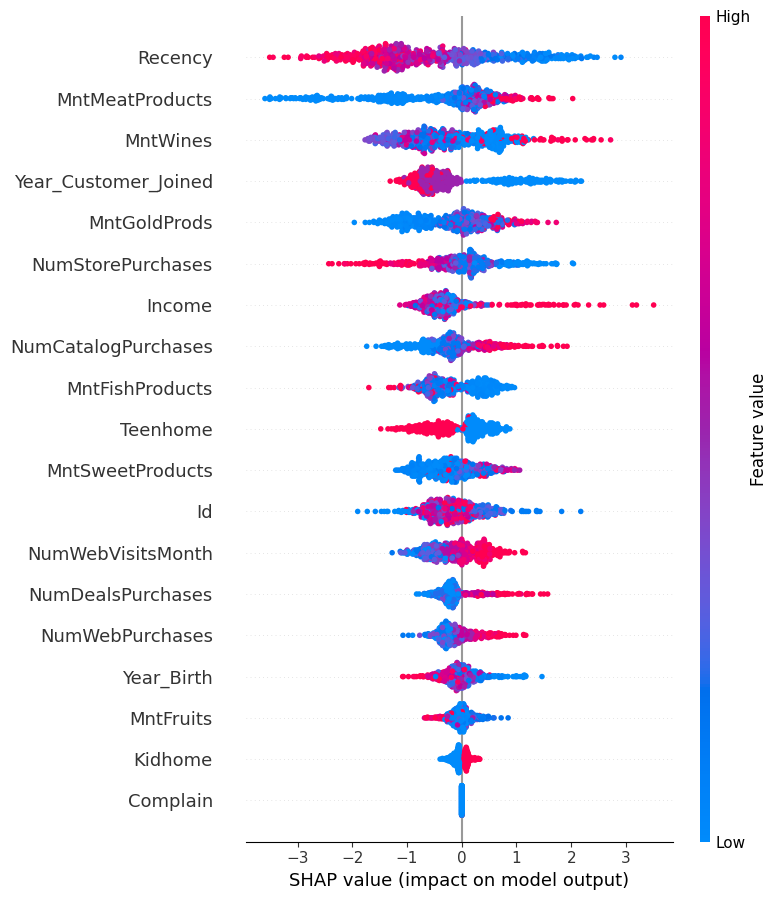

In [ ]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Summary plot (interactive)
shap.summary_plot(shap_values, X_test)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Logistic Regression pipeline with scaling
log_model = make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', max_iter=1000))
log_model.fit(X_train, y_train)

# Predictions and evaluation
y_log_pred = log_model.predict(X_test)
y_log_prob = log_model.predict_proba(X_test)[:, 1]

print("Logistic Regression Report:\n")
print(classification_report(y_test, y_log_pred))
print(f"Logistic Regression ROC AUC: {roc_auc_score(y_test, y_log_prob):.4f}")


Logistic Regression Report:

              precision    recall  f1-score   support

           0       0.96      0.74      0.84       572
           1       0.35      0.81      0.49       100

    accuracy                           0.75       672
   macro avg       0.66      0.78      0.66       672
weighted avg       0.87      0.75      0.78       672

Logistic Regression ROC AUC: 0.8618


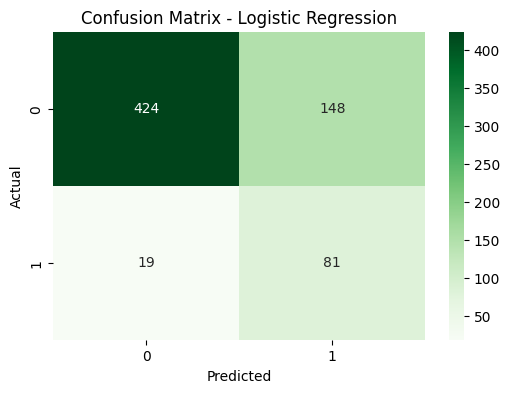

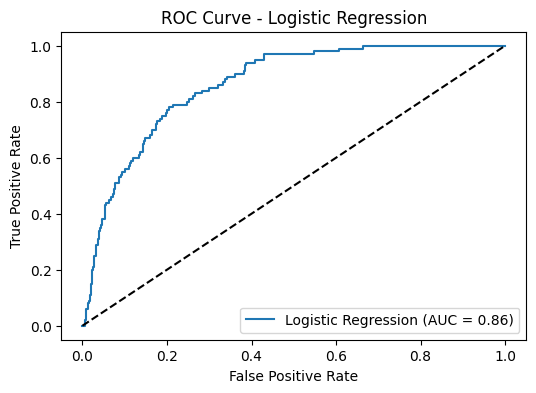

In [ ]:
# Confusion Matrix for Logistic Regression
log_cm = confusion_matrix(y_test, y_log_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(log_cm, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr_log, tpr_log, _ = roc_curve(y_test, y_log_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC = {roc_auc_score(y_test, y_log_prob):.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.show()


In [ ]:
# Create a DataFrame with predictions and probabilities
results_df = X_test.copy()
results_df["Actual"] = y_test.values
results_df["Predicted_XGB"] = y_pred
results_df["Probability_XGB"] = y_prob

# Save to CSV
results_df.to_csv("xgboost_predictions.csv", index=False)
print("Predictions saved to xgboost_predictions.csv")

# Save model metrics
metrics = {
    "Model": ["XGBoost", "Logistic Regression"],
    "ROC AUC": [roc_auc_score(y_test, y_prob), roc_auc_score(y_test, y_log_prob)],
    "Accuracy": [
        (y_test == y_pred).mean(),
        (y_test == y_log_pred).mean()
    ]
}
pd.DataFrame(metrics).to_csv("model_metrics_comparison.csv", index=False)
print("Metrics saved to model_metrics_comparison.csv")


Predictions saved to xgboost_predictions.csv
Metrics saved to model_metrics_comparison.csv


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_rf_pred = rf_model.predict(X_test)
y_rf_prob = rf_model.predict_proba(X_test)[:, 1]

print("Random Forest Report:\n")
print(classification_report(y_test, y_rf_pred))
print(f"Random Forest ROC AUC: {roc_auc_score(y_test, y_rf_prob):.4f}")


Random Forest Report:

              precision    recall  f1-score   support

           0       0.88      0.98      0.93       572
           1       0.68      0.23      0.34       100

    accuracy                           0.87       672
   macro avg       0.78      0.61      0.64       672
weighted avg       0.85      0.87      0.84       672

Random Forest ROC AUC: 0.8822


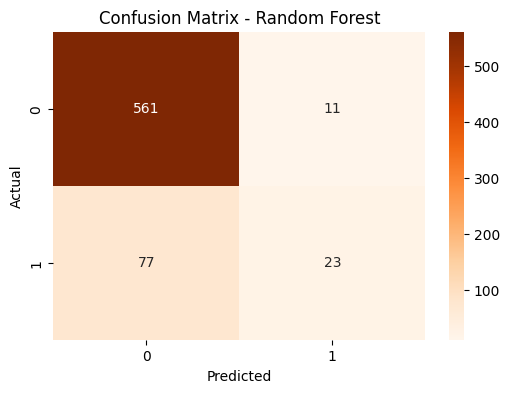

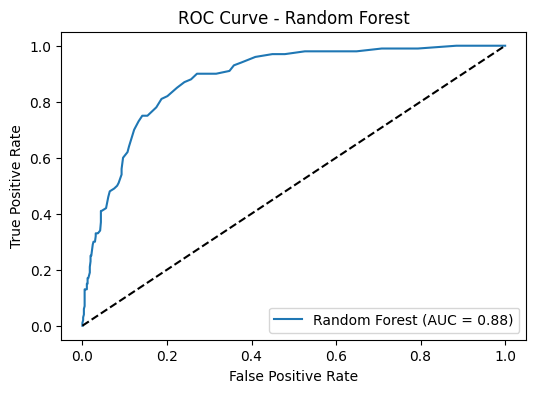

In [ ]:
# Confusion Matrix for Random Forest
rf_cm = confusion_matrix(y_test, y_rf_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Oranges')
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_rf_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_score(y_test, y_rf_prob):.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.show()


In [ ]:
# Compare all models: XGBoost, Logistic Regression, Random Forest
metrics = {
    "Model": ["XGBoost", "Logistic Regression", "Random Forest"],
    "ROC AUC": [
        roc_auc_score(y_test, y_prob),               # XGBoost
        roc_auc_score(y_test, y_log_prob),           # Logistic
        roc_auc_score(y_test, y_rf_prob)             # Random Forest
    ],
    "Accuracy": [
        (y_test == y_pred).mean(),
        (y_test == y_log_pred).mean(),
        (y_test == y_rf_pred).mean()
    ]
}

comparison_df = pd.DataFrame(metrics)
display(comparison_df)

,Model,ROC AUC,Accuracy
0,XGBoost,0.877133,0.875000
1,Logistic Regression,0.861766,0.751488
2,Random Forest,0.882159,0.869048


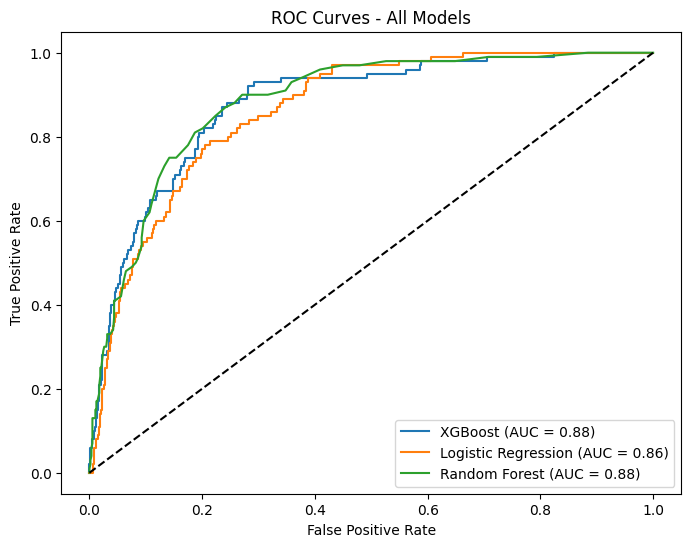

In [ ]:
# Compare all three ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"XGBoost (AUC = {roc_auc_score(y_test, y_prob):.2f})")
plt.plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC = {roc_auc_score(y_test, y_log_prob):.2f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_score(y_test, y_rf_prob):.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - All Models")
plt.legend()
plt.show()